### 1. Data downloading and exploration

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = load_dataset("banking77")

train = dataset["train"]
test = dataset["test"]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 10003
Test size: 3080


In [3]:
df_train = train.to_pandas()
df_test = test.to_pandas()

df_train.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


#### 1.1. Data exploration - dtypes, dataset size, classes range etc.

In [4]:
print("Train info:")
print(df_train.info())

print("\nTest info:")
print(df_test.info())

print("\nSample labels:", df_train["label"].unique()[:10])
print("Min label:", df_train["label"].min())
print("Max label:", df_train["label"].max())

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3080 entries, 0 to 3079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3080 non-null   object
 1   label   3080 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.3+ KB
None

Sample labels: [11 13 32 17 34 46 36 12  4 14]
Min label: 0
Max label: 76


#### 1.2. Text lengths histogram

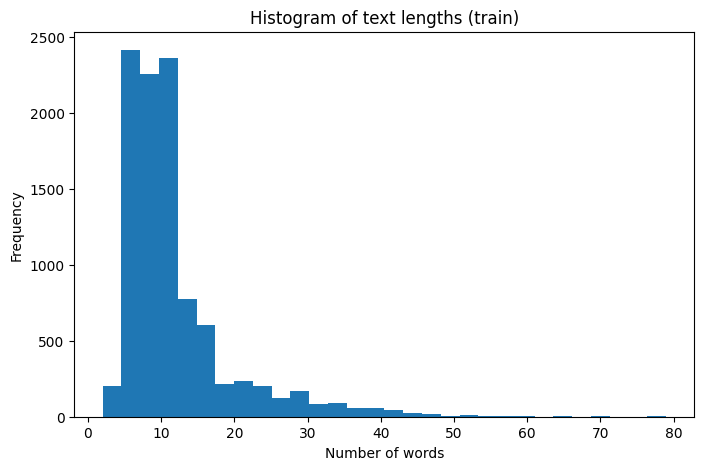

In [5]:
train_lengths = df_train["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(train_lengths, bins=30)
plt.title("Histogram of text lengths (train)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

#### 1.3. Class distribution

C:\Users\bstepniewski_vr\AppData\Local\Temp\ipykernel_13260\1574729949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train["label"], palette="viridis")


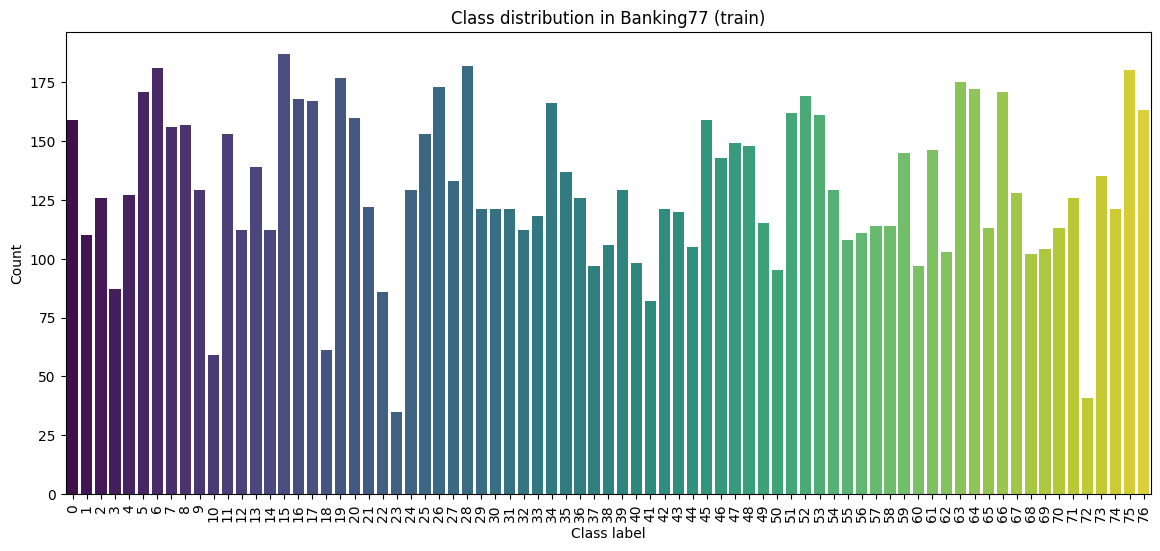

In [6]:
plt.figure(figsize=(14,6))
sns.countplot(x=df_train["label"], palette="viridis")
plt.title("Class distribution in Banking77 (train)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [7]:
print("Average text length:", train_lengths.mean())
print("Median text length:", train_lengths.median())
print("Max length:", train_lengths.max())
print("Min length:", train_lengths.min())

Average text length: 11.949415175447365
Median text length: 10.0
Max length: 79
Min length: 2


### 2. Cleaning data w. Cleanlab

#### 2.1. Model training and embedding

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer

texts_train = df_train["text"].to_numpy()
labels_train = df_train["label"].to_numpy()

embedder = SentenceTransformer("all-MiniLM-L6-v2")

emb_train = embedder.encode(texts_train, show_progress_bar=True, batch_size=64)
emb_train = np.asarray(emb_train)
emb_train.shape

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(10003, 384)

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

clf = LogisticRegressionCV(
    Cs=10,
    cv=5,
    max_iter=2000,
    multi_class="auto",
    class_weight="balanced",
    n_jobs=-1,
)

pred_probs = cross_val_predict(
    clf,
    emb_train,
    labels_train,
    cv=5,
    method="predict_proba",
    n_jobs=-1,
)
pred_probs.shape


(10003, 77)

#### 2.2. Running DataLab

In [10]:
from cleanlab import Datalab

data_dict = {
    "text": texts_train,
    "label": labels_train,
}

lab = Datalab(data_dict, label_name="label", task="classification")
lab.find_issues(pred_probs=pred_probs, features=emb_train)
issues = lab.get_issues()
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 632 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         150
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

#### 2.3. Duplicates

In [11]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in duplicate_issues.head(10).iterrows():
    text = texts_train[idx]
    neighbors = texts_train[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print(f"Idxes: {idx}, Near duplicate idxes: {row['near_duplicate_sets'][:3]}")
    print()

Text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates: ['I put the wrong pin too many times and now it is blocked. Can you help me unblock it?']
Idxes: 1710, Near duplicate idxes: [1724]

Text: 
I can't seem to be able to use my card



	Duplicates: ["I can't seem to be able to use my card"]
Idxes: 1290, Near duplicate idxes: [1246]

Text: I can't seem to be able to use my card
	Duplicates: ["\nI can't seem to be able to use my card\n\n\n"]
Idxes: 1246, Near duplicate idxes: [1290]

Text: Where can I withdraw money from?
	Duplicates: ['\nWhere can I withdraw money from?']
Idxes: 4594, Near duplicate idxes: [4595]

Text: 
Where can I withdraw money from?
	Duplicates: ['Where can I withdraw money from?']
Idxes: 4595, Near duplicate idxes: [4594]

Text: How can I reset my passcode?
	Duplicates: ['How can i reset my passcode ?' 'How do I reset my passcode?']
Idxes: 4903, Near duplicate idxes: [4915 4839]

Text: How can i reset my passcode 

In [12]:
df_train["text_lower"] = df_train["text"].str.lower()
df_deduplicated = df_train.drop_duplicates(subset="text_lower")
df_deduplicated = df_deduplicated.drop(columns="text_lower")
df_deduplicated = df_deduplicated.reset_index(drop=True)
df_deduplicated

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


#### 2.4. Label Issues

In [13]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts_train[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()


Top 10 label issues
y_true 11, y_pred 14, text: WHAT IS THE SOLUTION OF THIS PROBLEM

y_true 29, y_pred 40, text: i am not a premium customer but i want a virtual card, how do i get it

y_true 41, y_pred 11, text: Can you tell me the status of my new card?

y_true 27, y_pred 7, text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account

y_true 14, y_pred 49, text: Can I use app to reset PIN attempts?

y_true 49, y_pred 38, text: Where do I find PIN for my card?

y_true 47, y_pred 62, text: i put money on my card and i dont see it on the balance

y_true 26, y_pred 14, text: Is my card actually working? It's the first time I tried using it

y_true 5, y_pred 48, text: My transfer is pending too long.

y_true 65, y_pred 54, text: What currencies can I use to top up my account?



In [14]:
# make sure we don't get key errors - we removed some rows earlier during deduplication
label_issues = label_issues[label_issues.index.isin(df_deduplicated.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed = df_deduplicated.copy()
df_fixed.loc[idxs, "label"] = pred_labels
df_fixed

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


#### 2.5. Outliers

In [15]:
outliers = lab.get_issues("outlier")
outliers = outliers[outliers["is_outlier_issue"]]
outliers = outliers.sort_values(by="outlier_score")

print("Top 10 outlier issues")
for idx, row in outliers.head(10).iterrows():
    text = texts_train[idx]
    score = row["outlier_score"]
    print(f"Outlier score: {score:.4f}, text: {text}")

Top 10 outlier issues
Outlier score: 0.0051, text: WHAT IS THE ATMOSPHERE OF IT
Outlier score: 0.0063, text: what is the word?
Outlier score: 0.0079, text: What is this witdrawal
Outlier score: 0.0079, text: what is the matter?
Outlier score: 0.0087, text: WHAT IS THE SOLUTION OF THIS PROBLEM
Outlier score: 0.0107, text: I prefer Mastecard.
Outlier score: 0.0164, text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?
Outlier score: 0.0167, text: WHAT IS THE MAIN REASON OF THIS PROBLEM
Outlier score: 0.0168, text: WHAT IS THE REASON FOR THAT
Outlier score: 0.0189, text: why was i chargged


In [16]:
#removing outliers
outlier_idxs = outliers.index.tolist()
df_final = df_fixed.drop(index=outlier_idxs)
df_final = df_final.reset_index(drop=True)
df_final

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9867,I just moved to the US how do I get a card?,24
9868,You provide support in what countries?,24
9869,What countries are you supporting?,24
9870,What countries are getting support?,24


#### 2.6. Discussion

### 3. Classifier

#### 3.1. Train test split

In [17]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

valid_size = 0.2
df_train_final, df_valid = train_test_split(df_final, test_size=valid_size, random_state=0, stratify=df_final["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train_final, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [18]:
from transformers import AutoTokenizer
import joblib

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7897 [00:00<?, ? examples/s]

Map:   0%|          | 0/1975 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

#### 3.2. Models

In [19]:
import os
import random

from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments
from sklearn.metrics import f1_score

# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


# freeze some weights to speed up training
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    # y_pred_proba = np.argmax(softmax(logits, dim=1).numpy(), axis=1)
    y_pred = torch.argmax(logits, dim=1).numpy()

    f1 = f1_score(y_true, y_pred, average="macro")
    mcc = matthews_corrcoef(y_true, y_pred)

    return {
        "f1_macro": f1,
        "mcc": mcc,
    }

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="finetuned_hw_model",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=3e-5,
    num_train_epochs=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1_macro",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    label_smoothing_factor = 0.2,
    seed=0,
    data_seed=0,
    fp16=False,  # comment this out if you have unsupported hardware
    bf16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Macro,Mcc
1,No log,2.235732,0.751453,0.761426
2,No log,2.234852,0.754134,0.763486
3,No log,2.232858,0.752101,0.762447
4,No log,2.231336,0.751052,0.761929
5,No log,2.230849,0.753051,0.763474
6,No log,2.229657,0.755532,0.764501
7,No log,2.229311,0.754599,0.764508
8,No log,2.227855,0.755224,0.765003
9,No log,2.227377,0.755553,0.766044
10,No log,2.226049,0.756295,0.765519


TrainOutput(global_step=620, training_loss=2.21983391546434, metrics={'train_runtime': 161.9304, 'train_samples_per_second': 975.357, 'train_steps_per_second': 3.829, 'total_flos': 3805272369916560.0, 'train_loss': 2.21983391546434, 'epoch': 20.0})

##### F1 = 0.76 seems to be max for the model. Let's try with different, bigger model

In [38]:
model2 = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=77)

training_args2 = TrainingArguments(
    output_dir="finetuned_deberta_v3_base_debug",

    # prosto i stabilnie
    bf16=True,
    fp16=False,
    gradient_checkpointing=False,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,

    learning_rate=3e-5,
    num_train_epochs=50,
    warmup_ratio=0.1,
    weight_decay=0.01,

    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1_macro",
    load_best_model_at_end=True,
    save_total_limit=1,

    seed=0,
    data_seed=0,
    dataloader_num_workers=2,
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer2.train()

Epoch,Training Loss,Validation Loss,F1 Macro,Mcc
1,No log,4.331219,0.000427,-0.000023
2,No log,4.187308,0.002550,0.012498
3,4.328400,3.909492,0.005468,0.040188
4,4.328400,3.586330,0.013618,0.058022
5,3.925000,3.286763,0.033163,0.084114
6,3.925000,3.080312,0.081204,0.132227
7,3.305400,2.656657,0.134852,0.206662
8,3.305400,2.237070,0.198499,0.283945
9,2.607700,2.060040,0.246755,0.315747
10,2.607700,1.790695,0.375961,0.438975


TrainOutput(global_step=12350, training_loss=0.9057035436900521, metrics={'train_runtime': 2134.5699, 'train_samples_per_second': 184.979, 'train_steps_per_second': 5.786, 'total_flos': 1.872744140568132e+16, 'train_loss': 0.9057035436900521, 'epoch': 50.0})

#### 3.3. Calculation of predictions

In [ ]:
pred_output = trainer2.predict(datasets_tokenized["test"])
logits = pred_output.predictions
proba = torch.softmax(torch.tensor(logits), dim=1).numpy()
y_test = np.array(datasets_tokenized["test"]["label"])
y_pred = np.argmax(proba, axis=1)

### 4. Metrics

#### 4.1. Basic metrics

In [49]:
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score

print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC: {roc_auc_score(y_test, proba, multi_class='ovo', average='macro'):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

Precision: 87.29%
Recall: 86.82%
F1-score: 86.80%
AUROC: 98.87%
MCC: 86.65%


#### 4.2. F1 per class

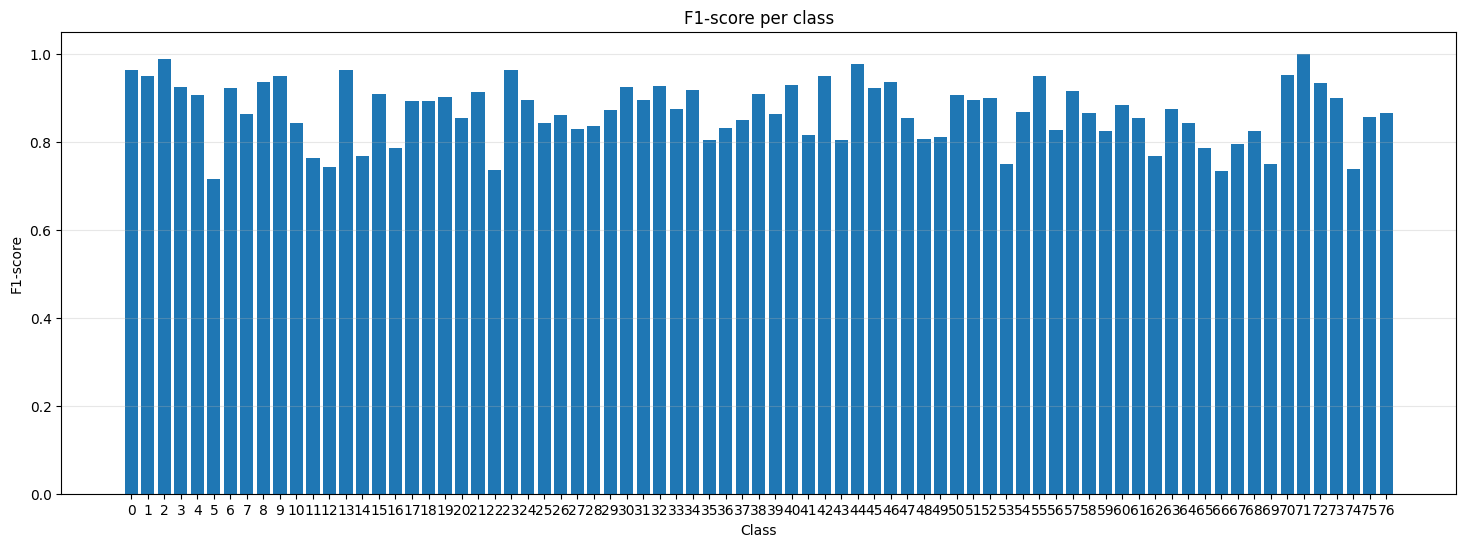

In [50]:
f1_per_class = f1_score(y_test, y_pred, average=None)

classes = np.arange(len(f1_per_class))

plt.figure(figsize=(18, 6))
plt.bar(classes, f1_per_class)
plt.title("F1-score per class")
plt.xlabel("Class")
plt.ylabel("F1-score")
plt.xticks(classes)
plt.grid(axis='y', alpha=0.3)
plt.show()

#### 4.3. Comment

* Achieved F1-Score is slightly slower but comparable with F1 declared in paper(0.86 to 0.92 - best result in paper)
* Without defined model purpose/usage I can't answer are this results enough or not, but they seems to be enough for most of tasks
* There are visible moderate differences between F1s of each class, especially classes with F1 =~ 1 are very interesting. Fortunately, we cant see any class with really low F1(all F1s are above 0.75, most even above 0.8)

### 5. Giskard analysis

#### 5.1. Giskard def, prediction_function fixes

In [53]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

trained_model = trainer2.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification", 
    model=trained_model, 
    tokenizer=tokenizer,
    top_k = None,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())
    probs = np.array([item["score"] for pred in pred_output for item in pred]).reshape(len(df), -1)
    return probs


giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=list(range(77)),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use cuda


2025-11-27 23:11:07,534 pid:13260 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-27 23:11:07,535 pid:13260 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-27 23:11:07,543 pid:13260 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-27 23:11:07,712 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.172733
2025-11-27 23:11:07,716 pid:13260 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-27 23:11:07,729 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.016456
2025-11-27 23:11:07,733 pid:13260 MainThread giskard.datasets.base 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


2025-11-27 23:12:25,706 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.014230
2025-11-27 23:12:25,707 pid:13260 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-27 23:12:25,721 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.014858
2025-11-27 23:12:25,723 pid:13260 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-27 23:12:25,737 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.013798
2025-11-27 23:12:25,738 pid:13260 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-27 23:12:25,753 pid:13260 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) exe

<iframe id="scan-2469124165072" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:

#### 5.2. Comment

Giskard have shown very important thing - despite great metrics model totally mismatches words connected with finance - it seems like a classical example of data slicing issue.

Probably the reason of the issue is imbalance of the classes connected with finance.

Proposed solutions are oversampling of classes with those kind of tokens or fine-tuning of problematic slices

### 6. Captum

#### 6.1. Captum setup

In [58]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    #for param in model.distilbert.parameters():
    for param in model.deberta.parameters():
        param.requires_grad = True
    
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, #"distilbert.embeddings")
        "deberta.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=y_true,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])
    
    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        probs = softmax(logits, dim=1).cpu().numpy()[0]

        y_pred = int(np.argmax(probs))
        y_pred_proba = float(probs[y_true])

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]
    
    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

#### 6.2. Checking few examples(especially from mismatching classes)

In [59]:
df_first3_class0 = df_final[df_final.label == 0].head(2) #Wrong class was 0
df_first3_class13 = df_final[df_final.label == 13].head(2) #class which was confused with 0
df_first3_class56 = df_final[df_final.label == 56].head(2) #class which was confused with 0
df_first3_class30 = df_final[df_final.label == 30].head(2)

for _, row in pd.concat([df_first3_class0, df_first3_class13, df_first3_class56, df_first3_class30]).iterrows():
    explain_text(
        model=trained_model, 
        text=row.text, 
        y_true=row.label
    )

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),1,-0.21,please help me with my card . it won ' t activate .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (1.00),1,-0.45,i tired but an unable to activate my card .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
13,13 (1.00),1,-0.94,my card has been found . is there any way for me to put it back into the app ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
13,13 (1.00),1,0.13,i was able to find my card . how to i go about putting it into my app ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
56,56 (1.00),1,-0.38,is there a top up fee for transfer ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
56,56 (1.00),1,0.54,will there be a charge for topping up by account with a sep ##a transfer ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
30,30 (1.00),1,1.47,i am interested in changing my personal details .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
30,30 (1.00),1,0.65,i am here to change my ad ##ress .


#### 6.3. Comment

At the first glimp of an eye it seems that model put emphasis on reasonable words.

One of the examples are especially interesting - in example 4. word "fee" strongly<i>tried</i> to change the class of sentence - it corresponds with problem with financial words found in Giskard.